In [ ]:
# Necessary imports to read the datasets
import pandas as pd
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_consumption_by_id(dataframe, id_value, column='Accumulated consumption (L/day)'):
    """
    Plots a time series of accumulated consumption for a given ID.

    Parameters:
    - dataframe: the input DataFrame
    - id_value: the specific ID to filter and plot
    - column: the name of the column to plot (default is 'Accumulated consumption (L/day)')
    """
    ts = dataframe[dataframe['id'] == id_value].sort_values('Date')

    if ts.empty:
        print(f"No data found for ID: {id_value}")
        return

    plt.figure(figsize=(12, 4))
    plt.plot(ts['Date'], ts[column], linestyle='-', linewidth=1.2)
    plt.title(f"{column} for: {id_value}")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [ ]:
# We have to properly select a dataset for testing
from google.colab import drive
drive.mount('/content/drive')

# Google Colab
file_path = "/content/drive/MyDrive/Colab Notebooks/TFG/data/01_datasets/df_domestic_cleaned_modified.csv"
df = pd.read_csv(file_path, low_memory=False)

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['id', 'Date'])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# We will compare the mean of the train set with the one it is supposed to be the test set
# We want to avoid data with error in the last months because a decreasing tendency has been observed in a lot of time series because of the incresing number of meters
# We avoid summer 2023

Top 5 series with the largest absolute percentage shift from historical to recent period:
ID: 0801910030_Barcelona, Absolute percentage shift: 46.98%


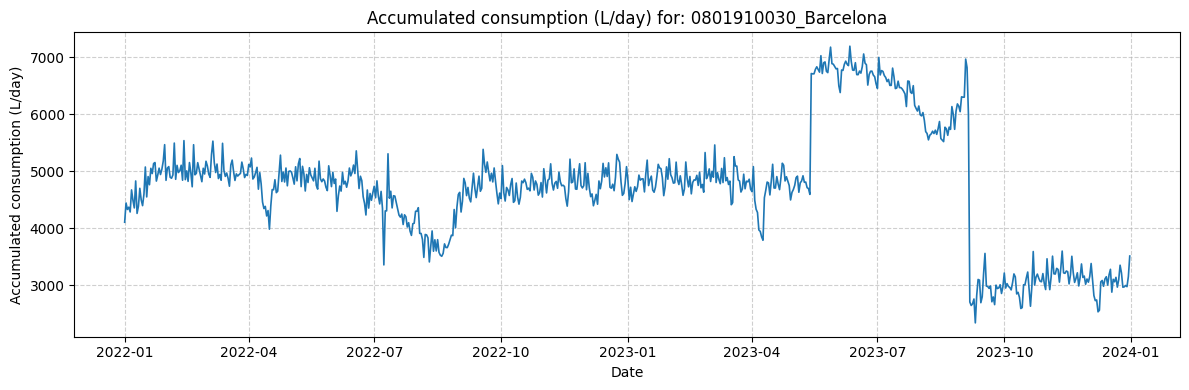

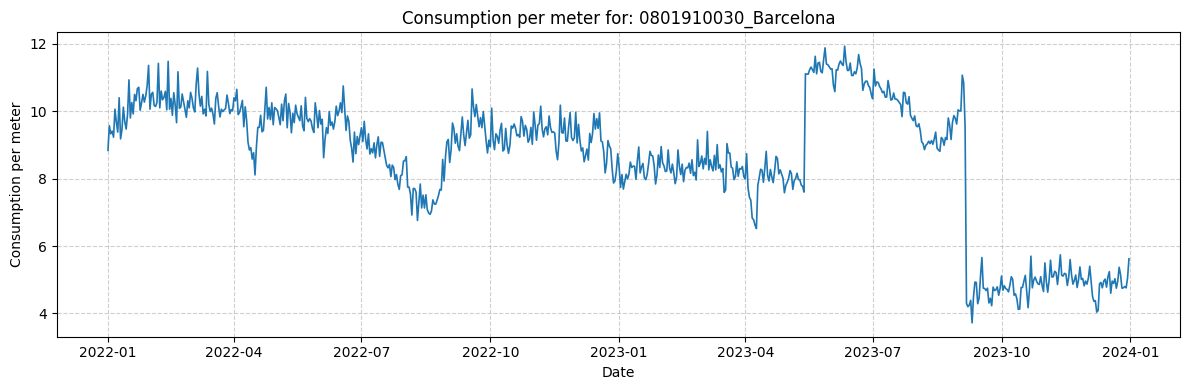

ID: 0801906024_Barcelona, Absolute percentage shift: 40.32%


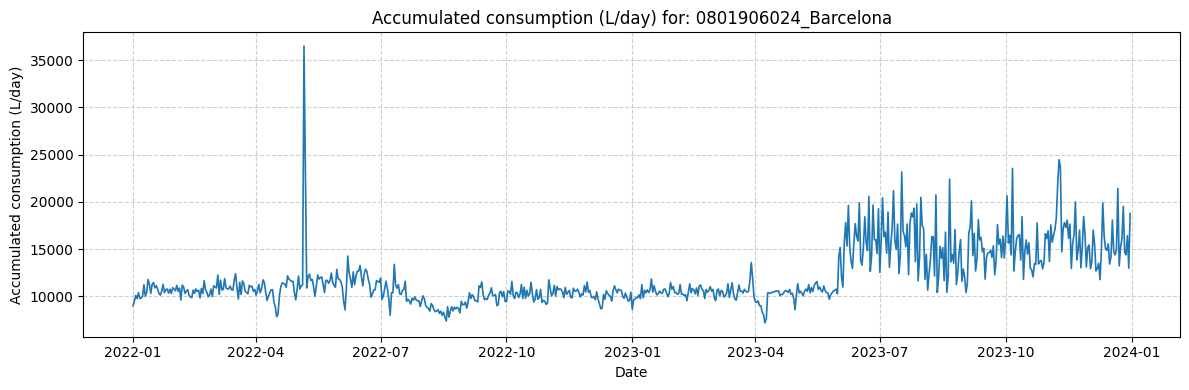

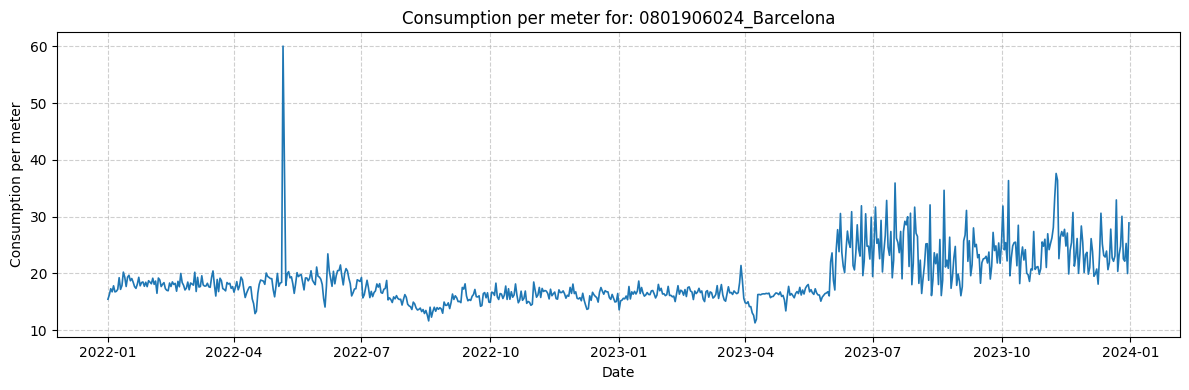

ID: 0801905037_Barcelona, Absolute percentage shift: 36.15%


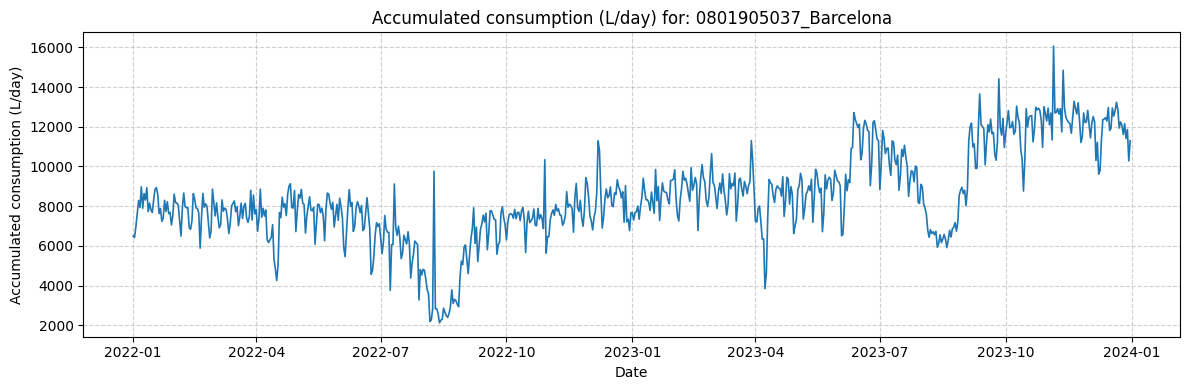

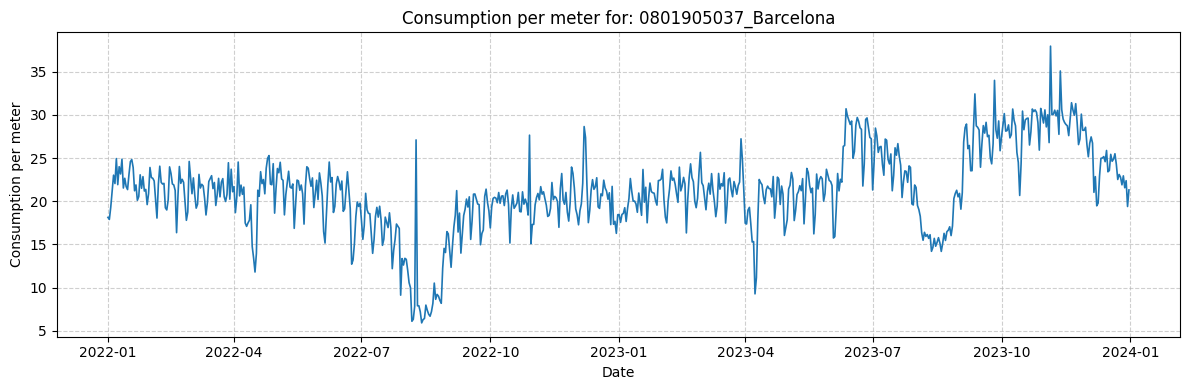

ID: 0810102034_Barcelona, Absolute percentage shift: 35.74%


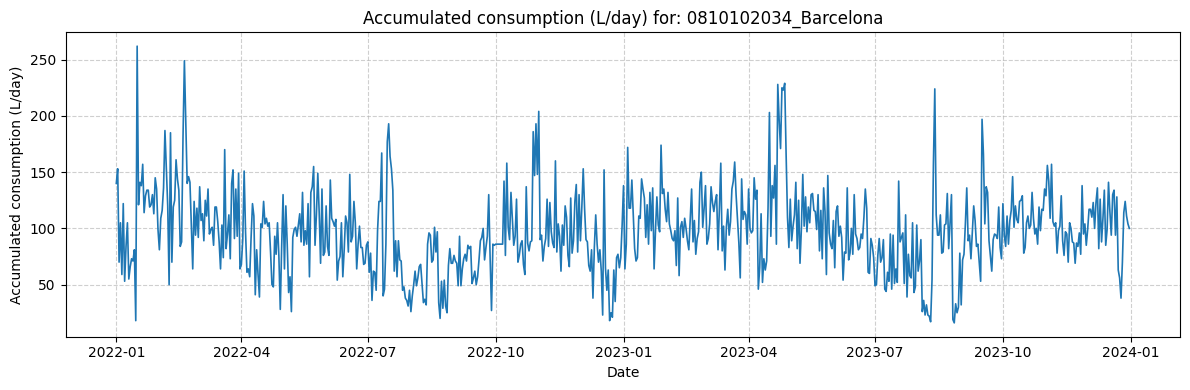

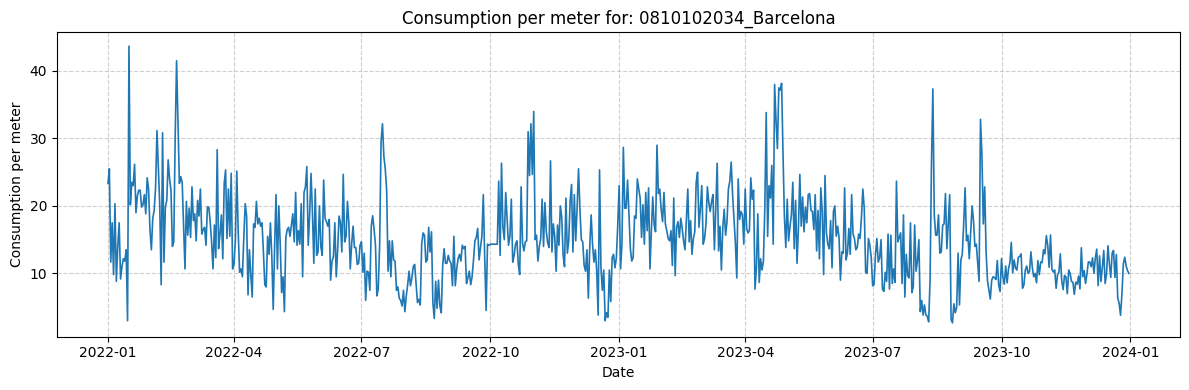

ID: 0801910083_Barcelona, Absolute percentage shift: 34.71%


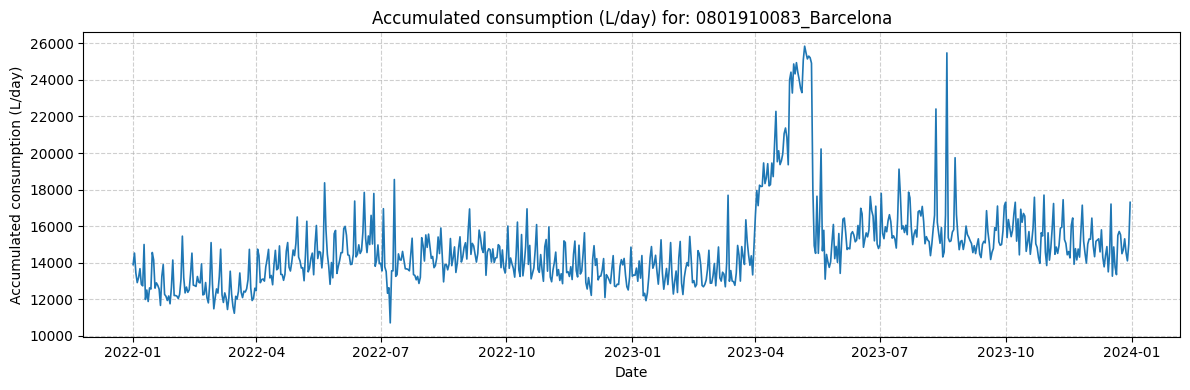

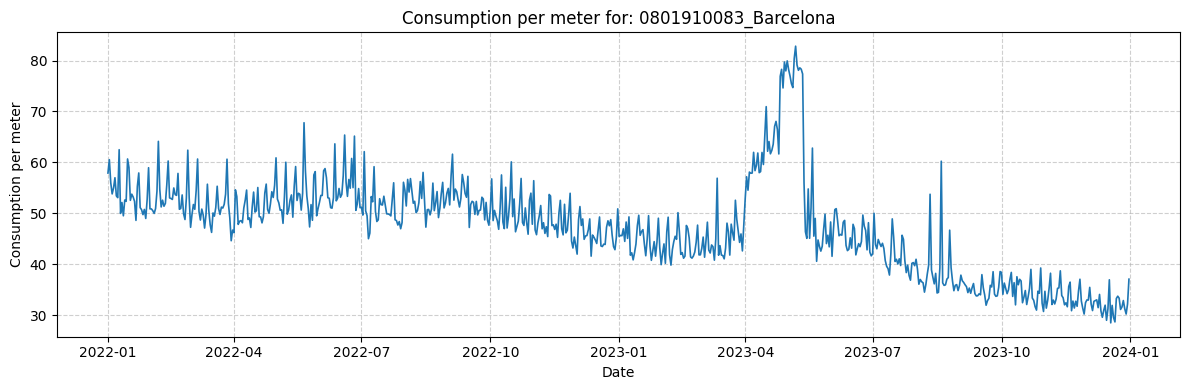

In [ ]:
# Add Year and Month columns
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

mean_diffs = []

# Group by series ID
for series_id, group in df.groupby('id'):
    # Historical: all of 2022 + Jan–Jun 2023
    historical = group[
        ((group['Year'] == 2022)) |
        ((group['Year'] == 2023) & (group['Month'] <= 6))
    ]['Consumption per meter']

    # Recent: Oct–Dec 2023
    recent = group[
        (group['Year'] == 2023) & (group['Month'] >= 10)
    ]['Consumption per meter']

    # Skip if either part is missing or historical mean is zero
    if historical.empty or recent.empty:
        continue
    historical_mean = historical.mean()
    if historical_mean == 0:
        continue

    # Compute absolute percentage change
    percent_diff = abs((recent.mean() - historical_mean) / historical_mean * 100)
    mean_diffs.append((series_id, percent_diff))

# Sort by percentage change descending
mean_diffs_sorted = sorted(mean_diffs, key=lambda x: x[1], reverse=True)

# Take the top 5
top_5 = mean_diffs_sorted[:5]

print("Top 5 series with the largest absolute percentage shift from historical to recent period:")
for series_id, percent_diff in top_5:
    print(f"ID: {series_id}, Absolute percentage shift: {percent_diff:.2f}%")
    plot_consumption_by_id(df, series_id)
    plot_consumption_by_id(df, series_id, column='Consumption per meter')


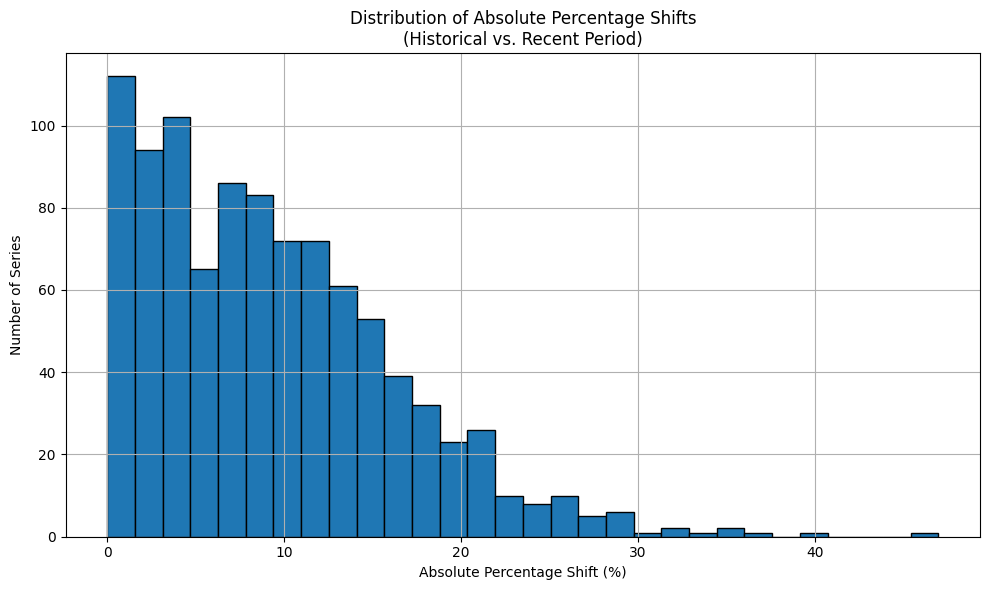

In [ ]:
import matplotlib.pyplot as plt

# Extract only the percentage shifts
percentage_shifts = [diff for _, diff in mean_diffs]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(percentage_shifts, bins=30, edgecolor='black')
plt.title("Distribution of Absolute Percentage Shifts\n(Historical vs. Recent Period)")
plt.xlabel("Absolute Percentage Shift (%)")
plt.ylabel("Number of Series")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Let's remove the time series with percent_diff <= 20%
valid_ids = [series_id for series_id, percent_diff in mean_diffs if percent_diff <= 20]

# We filter the df
df_filtered = df[df['id'].isin(valid_ids)]

print(f"Original number of series: {df['id'].nunique()}")
print(f"Remaining number of series after filtering: {df_filtered['id'].nunique()}")


Original number of series: 968
Remaining number of series after filtering: 890


In [ ]:
# Now let's select a new train - test over this new df

In [ ]:
df_filtered = df_filtered.sort_values(['id', 'Date'])
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])


In [ ]:
# Now we want to do a random selection of 50 time series
# Group by ID and count entries
series_counts = df_filtered.groupby('id').size()

# Filter IDs with exactly 730 entries
valid_ids = series_counts[series_counts == 730].index

print(f"Number of valid time series with exactly 730 entries: {len(valid_ids)}")

# Get first and last "Number of meters" per id
first_meters = df.groupby('id').first()['Number of meters']
last_meters = df.groupby('id').last()['Number of meters']

# Compute increase
increase = last_meters - first_meters

# Define ID groups based on increase
low_increase_ids = increase[increase < 50].index
medium_increase_ids = increase[(increase >= 50) & (increase < 200)].index
high_increase_ids = increase[increase >= 200].index

# Create three DataFrames
df_low_increase = df_filtered[df_filtered['id'].isin(low_increase_ids)]
df_medium_increase = df_filtered[df_filtered['id'].isin(medium_increase_ids)]
df_high_increase = df_filtered[df_filtered['id'].isin(high_increase_ids)]


Number of valid time series with exactly 730 entries: 890


In [ ]:
print(f"Series with <50 increase: {df_low_increase['id'].nunique()}")
print(f"Series with 100-199 increase: {df_medium_increase['id'].nunique()}")
print(f"Series with ≥200 increase: {df_high_increase['id'].nunique()}")


Series with <50 increase: 111
Series with 100-199 increase: 573
Series with ≥200 increase: 206


In [ ]:
# Define your groups (IDs only)
group_ids = [
    df_low_increase['id'].unique(),
    df_medium_increase['id'].unique(),
    df_high_increase['id'].unique()
]

# Define the sample sizes
weights = [60, 0, 0]

# To make selection reproducible
np.random.seed(10)

# Store sampled IDs here
selected_ids = []

# Loop over groups and weights
for ids_group, n_samples in zip(group_ids, weights):
    sampled = np.random.choice(ids_group, size=n_samples, replace=False)
    selected_ids.extend(sampled)

# Now selected_ids is a list of all sampled IDs
print(f"Total selected IDs: {len(selected_ids)}")
print(selected_ids)


Total selected IDs: 60
['0810106019_Hospitalet', '0810105007_Hospitalet', '0810104007_Hospitalet', '0810102007_Hospitalet', '0810102034_Hospitalet', '0810102024_Hospitalet', '0810101018_Hospitalet', '0810101029_Hospitalet', '0801903008_Barcelona', '0810101019_Hospitalet', '0810101040_Hospitalet', '0810104010_Hospitalet', '0810106023_Hospitalet', '0810104035_Hospitalet', '0801902043_Barcelona', '0801903213_Barcelona', '0810101011_Hospitalet', '0810102005_Hospitalet', '0810106026_Hospitalet', '0810101024_Hospitalet', '0810101004_Hospitalet', '0801904047_Barcelona', '0801904027_Barcelona', '0801910007_Barcelona', '0810106021_Hospitalet', '0810102045_Hospitalet', '0810106014_Hospitalet', '0801903021_Barcelona', '0810103022_Hospitalet', '0810103011_Hospitalet', '0810106032_Hospitalet', '0810105018_Hospitalet', '0810103018_Hospitalet', '0810105001_Hospitalet', '0810102048_Hospitalet', '0810101033_Hospitalet', '0810104011_Hospitalet', '0810102049_Hospitalet', '0810104033_Hospitalet', '0810103

In [ ]:
# 1. Get all unique IDs from the full DataFrame
all_ids_df = df_filtered['id'].unique()

# 2. Compute the unselected IDs
unselected_ids = list(set(all_ids_df) - set(selected_ids))

print(f"Total IDs in df: {len(all_ids_df)}")
print(f"Selected IDs: {len(selected_ids)}")
print(f"Unselected IDs: {len(unselected_ids)}")


Total IDs in df: 890
Selected IDs: 60
Unselected IDs: 830


In [ ]:
for series_id in selected_ids:
    plot_consumption_by_id(df, series_id)
    plot_consumption_by_id(df, series_id, column='Consumption per meter')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# We divide the df
test_df = df_filtered[df_filtered['id'].isin(selected_ids)]
train_df = df_filtered[~df_filtered['id'].isin(selected_ids)]

In [ ]:
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/TFG/data/01_datasets/train_test_reduced/test_reduced.csv', index=False)
train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/TFG/data/01_datasets/train_test_reduced/train_reduced.csv', index=False)